In [1]:
import datetime
import spiceypy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# load the kernels
spiceypy.furnsh("kernels/lsk/naif0012.tls")
spiceypy.furnsh("kernels/spk/de432s.bsp")

# get the current datetime and convert it to ET
date_time = datetime.datetime.now().strftime("%Y-%m-%dT%H:%M:%S")
date_time_et = spiceypy.utc2et(date_time)

/tmp/ipykernel_2673/3175073357.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
solar_system_df = pd.DataFrame()

solar_system_df.loc[:, "ET"] = [date_time_et]
solar_system_df.loc[:, "UTC"] = [date_time]

solarsystem_dictionary = {"sun": 10, "venus":299, "moon":301, "mars": 4, "jupiter": 5, "saturn": 6, "uranus": 7, "neptune": 8, "pluto": 9}

for planet in solarsystem_dictionary:
    # calculate the ecliptic coordinates of the planets as seen from earth
    solar_system_df.loc[:, f"{planet}_to_earth_ecliptic"] = solar_system_df["ET"].apply(lambda x: spiceypy.spkezp(targ=solarsystem_dictionary[planet], et=x, ref="ECLIPJ2000", abcorr="LT+S", obs=399)[0])
    
    # changes the vertices to longitude coordinates
    solar_system_df.loc[:, f"{planet}_long_radiants_ecliptic"] = solar_system_df[f"{planet}_to_earth_ecliptic"].apply(lambda x: spiceypy.recrad(x)[1])

    # changes the vertices to latitude coordinates
    solar_system_df.loc[:, f"{planet}_lat_radiants_ecliptic"] = solar_system_df[f"{planet}_to_earth_ecliptic"].apply(lambda x: spiceypy.recrad(x)[2])

    # invert the longitude coordinates to get the radiants for plotting
    solar_system_df.loc[:,f"{planet}_long_radiants4plot_ecliptic"] = solar_system_df[f"{planet}_long_radiants_ecliptic"].apply(lambda x: -1.0*((x%np.pi) - np.pi) if x >np.pi else -1.0*x)

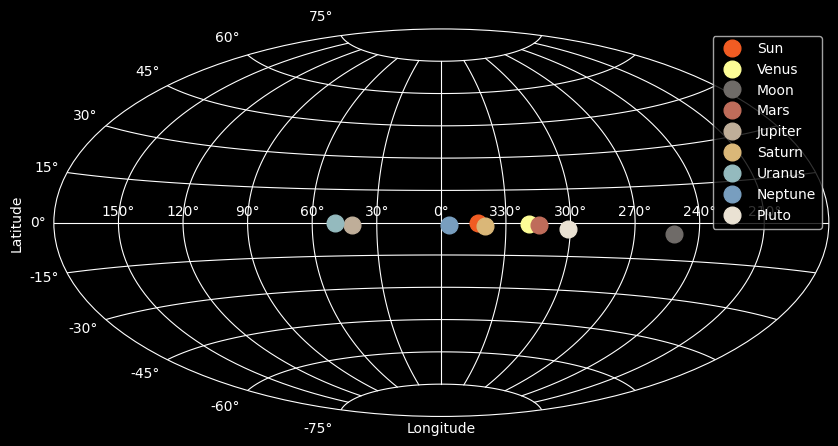

In [3]:
plt.style.use("dark_background")
plt.figure(figsize=(10, 10))

# the aitoff projection preserves longitude and latitude in its lines, so it is the best projection for this case
plt.subplot(projection="aitoff")

# make it pretty
plt.grid(True)
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# color array for the planets
body_color_array = ["#f15c23", "#FDFD96", "#6f6b68", "#BF6C5A", "#BFAE99", "#dab778", "#94babe", "#789ebf",  "#eae2d3"]

# add our data
for planet, color in zip(solarsystem_dictionary, body_color_array):
    plt.plot(solar_system_df[f"{planet}_long_radiants4plot_ecliptic"], solar_system_df[f"{planet}_lat_radiants_ecliptic"], color=color, linestyle = "None", marker= "o", markersize=12, label=planet.capitalize())

plt.xticks(ticks=np.radians(np.arange(-150,180,30)), labels=["150°", "120°", "90°", "60°", "30°", "0°", "330°", "300°", "270°", "240°", "210°"])

plt.legend()